/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 20/200 | D_loss: 98.4720 | G_loss: 0.1787
Epoch 40/200 | D_loss: 98.9904 | G_loss: 0.0908
Epoch 60/200 | D_loss: 99.4237 | G_loss: 0.0607
Epoch 80/200 | D_loss: 99.7205 | G_loss: 0.0456
Epoch 100/200 | D_loss: 99.9350 | G_loss: 0.0365
Epoch 120/200 | D_loss: 100.0745 | G_loss: 0.0305
Epoch 140/200 | D_loss: 100.1836 | G_loss: 0.0261
Epoch 160/200 | D_loss: 100.3066 | G_loss: 0.0229
Epoch 180/200 | D_loss: 100.3860 | G_loss: 0.0204
Epoch 200/200 | D_loss: 100.4327 | G_loss: 0.0183


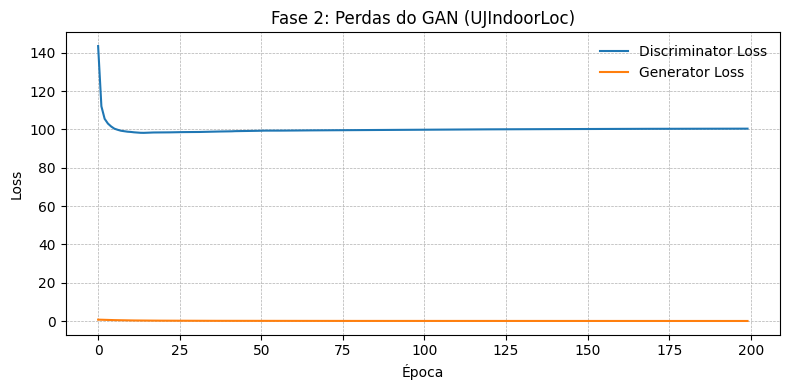

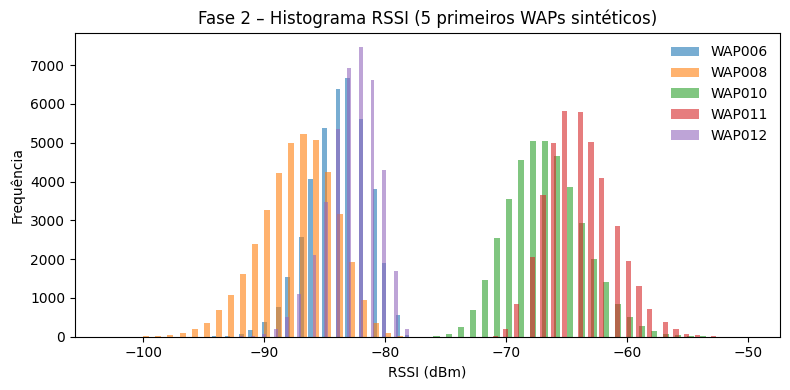

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Carregar e pré-processar UJIndoorLoc (Building 1, Floor 2)
# --------------------------------------------------
df_full = pd.read_csv("/home/darkcover/Documentos/Gan/Data/Real/trainingData.csv")
wap_cols = [c for c in df_full.columns if c.startswith("WAP")]
# substitui missing=100 por −110 dBm
df_full[wap_cols] = df_full[wap_cols].replace(100, -110)
# filtra B1-F2
df_env = df_full[(df_full.BUILDINGID == 1) & (df_full.FLOOR == 2)].copy()
# mantém apenas WAPs detectados ao menos uma vez (~190 colunas)
present_waps = [c for c in wap_cols if (df_env[c] != -110).any()]
X_real = df_env[present_waps].astype(np.float32).values

n_features = X_real.shape[1]    # ≈190
latent_dim  = n_features

# --------------------------------------------------
# 2. Definir Generator e Discriminator
# --------------------------------------------------
def build_generator():
    inp = Input(shape=(latent_dim,))
    x   = layers.Dense(10, activation="relu")(inp)
    out = layers.Dense(n_features, activation="linear")(x)
    return Model(inp, out, name="Generator")

def build_discriminator():
    inp = Input(shape=(n_features,))
    x   = layers.Dense(10, activation="relu")(inp)
    out = layers.Dense(1, activation="sigmoid")(x)
    return Model(inp, out, name="Discriminator")

generator    = build_generator()
discriminator = build_discriminator()

# --------------------------------------------------
# 3. Compilar Discriminator
# --------------------------------------------------
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy"
)

# --------------------------------------------------
# 4. Montar e compilar o GAN (D congelado)
# --------------------------------------------------
discriminator.trainable = False
gan_input  = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan        = Model(gan_input, gan_output, name="GAN")
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy"
)

# --------------------------------------------------
# 5. Treinamento do GAN
# --------------------------------------------------
epochs     = 200
batch_size = 100
half_batch = batch_size // 2
d_losses, g_losses = [], []

for epoch in range(1, epochs+1):
    # 5.1) Treina D com reais
    idx          = np.random.randint(0, X_real.shape[0], half_batch)
    real_batch   = X_real[idx]
    d_loss_real  = discriminator.train_on_batch(real_batch, np.ones((half_batch,1)))
    # 5.2) Treina D com falsos
    noise        = np.random.uniform(-1,1,(half_batch, latent_dim))
    fake_batch   = generator.predict(noise, verbose=0)
    d_loss_fake  = discriminator.train_on_batch(fake_batch, np.zeros((half_batch,1)))
    d_loss       = 0.5 * (d_loss_real + d_loss_fake)
    # 5.3) Treina G via GAN
    noise   = np.random.uniform(-1,1,(batch_size, latent_dim))
    g_loss  = gan.train_on_batch(noise, np.ones((batch_size,1)))
    d_losses.append(d_loss); g_losses.append(g_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

# --------------------------------------------------
# 6. Salvar modelos treinados
# --------------------------------------------------
generator.save("/home/darkcover/Documentos/Gan/Models/generator_phase2_UJ.keras")
discriminator.save("/home/darkcover/Documentos/Gan/Models/discriminator_phase2_UJ.keras")

# --------------------------------------------------
# 7. Plotagem das perdas
# --------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("Fase 2: Perdas do GAN (UJIndoorLoc)")
plt.xlabel("Época"); plt.ylabel("Loss")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8. Geração de 40 000 amostras sintéticas
# --------------------------------------------------
n_blocks           = 10   # 10×4 000 = 40 000
samples_per_block  = 4000
blocks = []
for _ in range(n_blocks):
    noise = np.random.uniform(-1,1,(samples_per_block, latent_dim))
    blocks.append(generator.predict(noise, verbose=0))
generated_raw = np.vstack(blocks)

# --------------------------------------------------
# 9. Reescalonamento para RSSI em [−110, −40] dBm
# --------------------------------------------------
min_raw, max_raw = generated_raw.min(), generated_raw.max()
scaled = (generated_raw - min_raw) / (max_raw - min_raw)
rssi   = scaled * 70 - 110
df_generated = pd.DataFrame(
    np.round(rssi).astype(int),
    columns=present_waps
).clip(-110, -40)
df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated_UJIndoorLoc.csv", index=False)

# --------------------------------------------------
# 10. Validação gráfica: histograma dos 5 primeiros WAPs
# --------------------------------------------------
plt.figure(figsize=(8,4))
for wap in present_waps[:5]:
    plt.hist(df_generated[wap], bins=50, alpha=0.6, label=wap)
plt.title("Fase 2 – Histograma RSSI (5 primeiros WAPs sintéticos)")
plt.xlabel("RSSI (dBm)"); plt.ylabel("Frequência")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


2025-05-22 06:18:10.035849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 06:18:10.131757: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 06:18:10.277367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747909090.355151  208410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747909090.376938  208410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747909090.553578  208410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 20/200 | D_loss: 2.6118 | G_loss: 0.1266
Epoch 40/200 | D_loss: 4.0216 | G_loss: 0.0637
Epoch 60/200 | D_loss: 4.7027 | G_loss: 0.0425
Epoch 80/200 | D_loss: 5.0914 | G_loss: 0.0319
Epoch 100/200 | D_loss: 5.3316 | G_loss: 0.0256
Epoch 120/200 | D_loss: 5.5091 | G_loss: 0.0213
Epoch 140/200 | D_loss: 5.6319 | G_loss: 0.0183
Epoch 160/200 | D_loss: 5.7344 | G_loss: 0.0160
Epoch 180/200 | D_loss: 5.8175 | G_loss: 0.0142
Epoch 200/200 | D_loss: 5.8880 | G_loss: 0.0128


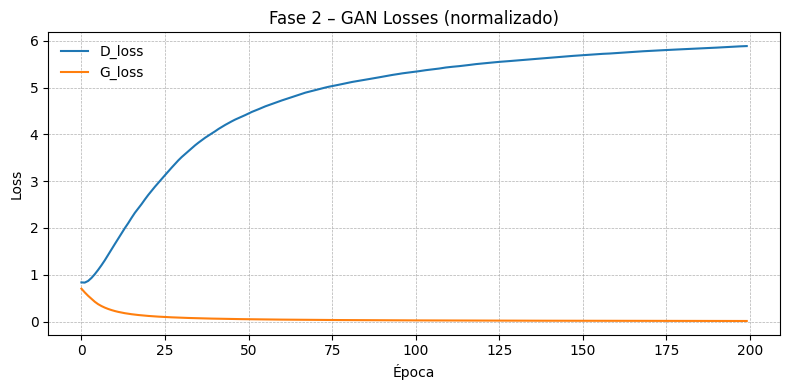

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Carregar e pré-processar UJIndoorLoc (B1–F2)
# --------------------------------------------------
df_full = pd.read_csv("/home/darkcover/Documentos/Gan/Data/Real/trainingData.csv")
wap_cols = [c for c in df_full.columns if c.startswith("WAP")]
df_full[wap_cols] = df_full[wap_cols].replace(100, -110)
df_env    = df_full[(df_full.BUILDINGID==1)&(df_full.FLOOR==2)].copy()
present_waps = [c for c in wap_cols if (df_env[c] != -110).any()]
X_real = df_env[present_waps].values.astype(np.float32)

# intervalo original de RSSI
RSSI_MIN, RSSI_MAX = -110.0, -40.0

# --------------------------------------------------
# 2. Normalização para [-1, 1]
# --------------------------------------------------
# x_norm = 2 * (x - min)/(max-min) - 1
X_real_norm = 2.0 * ( (X_real - RSSI_MIN) / (RSSI_MAX - RSSI_MIN) ) - 1.0

n_features = X_real_norm.shape[1]
latent_dim = n_features

# --------------------------------------------------
# 3. Definir Generator e Discriminator
# --------------------------------------------------
def build_generator():
    inp = Input(shape=(latent_dim,))
    x   = layers.Dense(10, activation="relu")(inp)
    out = layers.Dense(n_features, activation="linear")(x)
    return Model(inp, out, name="Generator")

def build_discriminator():
    inp = Input(shape=(n_features,))
    x   = layers.Dense(10, activation="relu")(inp)
    out = layers.Dense(1, activation="sigmoid")(x)
    return Model(inp, out, name="Discriminator")

generator     = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                      loss='binary_crossentropy')

# --------------------------------------------------
# 4. Montar GAN (com D congelado) e compilar
# --------------------------------------------------
discriminator.trainable = False
gan_in  = Input(shape=(latent_dim,))
gan_out = discriminator(generator(gan_in))
gan     = Model(gan_in, gan_out, name="GAN")
gan.compile(optimizer=tf.keras.optimizers.Adam(0.01),
            loss='binary_crossentropy')

# --------------------------------------------------
# 5. Treinamento do GAN usando X_real_norm
# --------------------------------------------------
epochs     = 200
batch_size = 100
half_batch = batch_size // 2
d_losses, g_losses = [], []

for epoch in range(1, epochs+1):
    # 5.1) treino D em real
    idx         = np.random.randint(0, X_real_norm.shape[0], half_batch)
    real_batch  = X_real_norm[idx]
    d_loss_real = discriminator.train_on_batch(real_batch,
                                               np.ones((half_batch,1)))
    # 5.2) treino D em fake
    noise       = np.random.uniform(-1,1,(half_batch, latent_dim))
    fake_batch  = generator.predict(noise, verbose=0)
    d_loss_fake = discriminator.train_on_batch(fake_batch,
                                               np.zeros((half_batch,1)))
    d_loss      = 0.5*(d_loss_real + d_loss_fake)
    # 5.3) treino G via GAN
    noise       = np.random.uniform(-1,1,(batch_size, latent_dim))
    g_loss      = gan.train_on_batch(noise, np.ones((batch_size,1)))

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

# --------------------------------------------------
# 6. Desnormalizar e salvar 40 000 amostras
# --------------------------------------------------
n_blocks, block_size = 10, 4000
gen_blocks = []
for _ in range(n_blocks):
    noise = np.random.uniform(-1,1,(block_size, latent_dim))
    gen_norm = generator.predict(noise, verbose=0)  # em [-1,1]
    # x = ( (x_norm+1)/2 )*(max-min) + min
    gen_rssi = ((gen_norm + 1.0)/2.0)*(RSSI_MAX - RSSI_MIN) + RSSI_MIN
    gen_blocks.append(gen_rssi)

gen_all   = np.vstack(gen_blocks)
df_generated = pd.DataFrame(np.round(gen_all).astype(int),
                            columns=present_waps).clip(RSSI_MIN, RSSI_MAX)
df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated_UJIndoorLoc.csv", index=False)

# --------------------------------------------------
# 7. Plot das perdas para conferir
# --------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(d_losses, label="D_loss")
plt.plot(g_losses, label="G_loss")
plt.title("Fase 2 – GAN Losses (normalizado)")
plt.xlabel("Época"); plt.ylabel("Loss")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
